## Meyer data preprocessing

This script helps us explore and process the Meyer data.

__author__ = "Ciro Ramírez-Suástegui"

__copyright__ = "Copyright 2022-01-18, Helmholtz Zentrum Muenchen"

__license__ = "GPL"

__version__ = "0.0.9"

__email__ = "ciro.suastegui@helmholtz-muenchen.de, ksuasteguic@gmail.com"

#### Structure

* [Load data](#bullet1)
* [Raw counts in adata.X](#bullet2)
* [Metadata harmonization](#bullet3)
* [Quality Control](#bullet4)
* [Remove doublets](#bullet5)
* [Make object lightweight](#bullet6)
* [Check if you need to split them into datasets](#bullet7)
* [Write down everything you did in the "preprocessing" column](#bullet8)
* [Subset to HVGs](#bullet8)
* [Store the data](#bullet10)
* [Update the stats for your dataset](#bullet11)

### Environment setup

In [1]:
# basic modules
import os, re, time, importlib
import sys, warnings, glob
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
# in-house/developing modules
sys.path.append("../../../scripts/")
import preprocessing as pp
# tools modules
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         9.0.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cached_property             1.5.2
cffi                        1.15.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints   

In [3]:
# setting visualisation parameters
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(10, 10))

In [4]:
print("Environment:", re.sub('.os.py', '', os.__file__))
parentpath = lambda _path, n: os.sep.join(_path.split(os.sep)[:-n])
print("Working at:", re.sub(parentpath(os.getcwd(), 2), '', os.getcwd()))

Environment: /home/icb/ciro.suastegui/miniconda3/envs/scarches_0_3_5/lib/python3.7
Working at: /3_atlas_extension/HLCA_extension_data_preprocessing


In [5]:
spam_spec = importlib.util.find_spec("load_ext")
if spam_spec is not None:
    %load_ext autoreload
    %autoreload 2
    %load_ext lab_black
else:
    print("No pretty code for us today")

No pretty code for us today


### Global variables and paths

In [6]:
adata_inp = "../../../data/HLCA_extended/extension_datasets/raw/Meyer/meyer_nikolic_2021_raw.h5ad"
adata_dir_out = "../../../data/HLCA_extended/extension_datasets/ready"
mdata_donor_inp = "../../../data/HLCA_extended/extension_datasets/metadata/MeyerNikolic_unpubl.xlsx"
genes_set_inp = "../../../notebooks/3_atlas_extension/HLCA_extension_data_preprocessing/genes_for_mapping.csv"

### Load data <a class="anchor" id="bullet1"></a>

In [7]:
adata = sc.read_h5ad(adata_inp)
adata_obs = adata.obs

In [8]:
adata

AnnData object with n_obs × n_vars = 236977 × 33582
    obs: 'sample_id', 'donor', 'Sex', 'Age_bin', 'Group', 'Ethnicity_inferred', 'Smoker', 'COVID_status', 'COVID_severity', 'First_symptoms_hospitalisation_interval', 'First_symptoms_collection_interval', 'Positive_test_collection_interval', 'Sample_location', 'Kit_version', 'dataset', 'Sanger_sample_ID', 'Cell_type_annotation_level3', 'Cell_type_annotation_level1', 'Cell_type_annotation_level2', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'n_counts_total_sarscov2', 'percent_total_sarscov2', 'n_counts_sarscov2', 'percent_sarscov2', 'scrublet_score'
    var: 'gene_ids', 'mito', 'ribo', 'sarscov2'
    obsm: 'X_pca', 'X_umap'

### Raw counts in adata.X <a class="anchor" id="bullet2"></a>

In [9]:
print(adata.layers, len(adata.layers))
print("Is adata.raw present?", adata.raw is not None)

Layers with keys:  0
Is adata.raw present? False


In [10]:
adata.X[:10,:10].A

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0., 10.]], dtype=float32)

In [11]:
pd.Series(adata.X[:100,:100].A.flatten()).value_counts()

0.0     9062
1.0      669
2.0      148
3.0       46
4.0       20
5.0       15
6.0       14
7.0        7
9.0        4
10.0       4
8.0        2
13.0       2
15.0       1
22.0       1
21.0       1
12.0       1
17.0       1
11.0       1
20.0       1
dtype: int64

### Metadata harmonization <a class="anchor" id="bullet3"></a>

Checking metadata and mapping obs names. I belive this should be the first step because it makes the pre-processing easier for new datasets (standarizing from an early step).

In [12]:
for i in list(set(adata_obs.columns) - set(adata_obs._get_numeric_data().columns)):
    print("=========", i); print(adata_obs[i].value_counts())

========= donor
NP32    12616
AP10    10449
NP13    10225
PP8      7336
PP18     7074
        ...  
NP11      143
NP41       93
PP19       75
PC9        37
AP12       21
Name: donor, Length: 74, dtype: int64
========= Cell_type_annotation_level1
Epi         200405
Myeloid      13279
B/Plasma     12908
T/NK/ILC     10385
Name: Cell_type_annotation_level1, dtype: int64
========= Sample_location
Nose       198868
Trachea     20987
Bronchi     17122
Name: Sample_location, dtype: int64
========= Group
Ped      167107
Adult     69870
Name: Group, dtype: int64
========= dataset
ucl    225305
nw      11672
Name: dataset, dtype: int64
========= Cell_type_annotation_level2
Goblet                  55090
Ciliated                37511
Basal                   29966
Secretory               29713
Goblet inflammatory     13651
Transit epi             11945
Club                     9181
B mem                    7495
Monocyte                 7150
T CD8                    4293
Macrophage               380

#### Extra sample metadata

Get it from the online [metadata](https://docs.google.com/spreadsheets/d/15a99JoSBO4kI47NskL4QwHR7fK14DUT7km75EgOytjs/edit#gid=0).

We simply used `wget.download`

In [13]:
sample_column = "sample_id"
mdata_index = "sample_ID"
mdata_donor = pd.read_excel(mdata_donor_inp, engine='openpyxl', header = 0, index_col=mdata_index)
mdata_donor = mdata_donor.iloc[3:,]
mdata_donor[mdata_index] = mdata_donor.index.tolist()
mdata = pp.metadata_match(adata_obs, sample_column, mdata_donor)

Number of samples in metadata: 97
Number of samples in anndata: 97
(97, 31)
Missing columns:
 library_ID
 publication_ID
 repository_ID
 age_range
 ethnicity_2
 ethnicity_free_text
 cause_of_death
 anatomical_region_level2
 sequencing_platform
 reference_genome_ensembl_release
 sample_collection_relative_timepoint
 disease_status
 treatment_status
 comments
(236977, 31)
Checking Difference between final and donor/sample medadata.


#### Setting metadata

In [14]:
# MANDATORY # &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
mdata["study"] = "MeyerNikolic_unpubl" # [Last_author]_[year]
# if no splitting into different datasets, use 'study'
mdata["dataset"] = adata_obs.dataset.map(dict(
    {"ucl": "MeyerNikolic_unpubl_UCL", "nw": "Meyer_Nikolic_unpubl_NW"}
))
mdata["sample"] = adata_obs[sample_column]
mdata["subject_ID"] = mdata["subject_ID_published"]
mdata["disease_condition"] = mdata["disease_condition"].fillna("Healthy")
mdata["original_celltype_ann"] = adata_obs.Cell_type_annotation_level3
# OPTIONAL # &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
# mdata["sex"]
# mdata["age"]
# mdata["ethnicity"]
# mdata["bmi"]
mdata["smoking_status"] = adata_obs.Smoker.map(dict(
    {"Non-smoker": "never", "Smoker": "active", "Ex-smoker": "former"}
))
# FELL FREE TO ADD MORE? # &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
mdata["ethnicity_free_text"] = adata_obs.Ethnicity_inferred
mdata["disease_status"] = adata_obs.COVID_status.tolist()
del mdata["anatomical_region_level3"] # supposed to have more details
mdata

,institute,study_PI,sample_ID,subject_ID,subject_ID_published,subject_developmental_state,age_years,sex,ethnicity_1,smoking_status,...,sample_status,sample_cultured,cell_number_loaded,cell_viability_percentage,study,dataset,sample,original_celltype_ann,ethnicity_free_text,disease_status
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGGAGTTGC-CV001_KM8853544-ucl,UCL/ Sanger Institute,Marko Nikolić/ Kerstin Meyer,NP10-NB,NP10,NP10,postnatal,5.0,male,white,never,...,fresh,no,5000.0,87.8,MeyerNikolic_unpubl,MeyerNikolic_unpubl_UCL,NP10-NB,Goblet 2 BPIFA2+,EUR,Healthy
AAACCTGAGTGGGCTA-CV001_KM8853544-ucl,UCL/ Sanger Institute,Marko Nikolić/ Kerstin Meyer,NP10-NB,NP10,NP10,postnatal,5.0,male,white,never,...,fresh,no,5000.0,87.8,MeyerNikolic_unpubl,MeyerNikolic_unpubl_UCL,NP10-NB,B mem exhausted,EUR,Healthy
AAACCTGCAAAGGCGT-CV001_KM8853544-ucl,UCL/ Sanger Institute,Marko Nikolić/ Kerstin Meyer,NP10-NB,NP10,NP10,postnatal,5.0,male,white,never,...,fresh,no,5000.0,87.8,MeyerNikolic_unpubl,MeyerNikolic_unpubl_UCL,NP10-NB,T gd,EUR,Healthy
AAACCTGCAATGAAAC-CV001_KM8853544-ucl,UCL/ Sanger Institute,Marko Nikolić/ Kerstin Meyer,NP10-NB,NP10,NP10,postnatal,5.0,male,white,never,...,fresh,no,5000.0,87.8,MeyerNikolic_unpubl,MeyerNikolic_unpubl_UCL,NP10-NB,T CD8 mem 1,EUR,Healthy
AAACCTGCACTGTCGG-CV001_KM8853544-ucl,UCL/ Sanger Institute,Marko Nikolić/ Kerstin Meyer,NP10-NB,NP10,NP10,postnatal,5.0,male,white,never,...,fresh,no,5000.0,87.8,MeyerNikolic_unpubl,MeyerNikolic_unpubl_UCL,NP10-NB,Goblet 2 BPIFA2+,EUR,Healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SC176_TTTGGTTGTCTTTCAT-1-nw,North Western University,NaN,BP4-BB,BP4,BP4,postnatal,66.0,male,latino,former,...,NaN,NaN,NaN,NaN,MeyerNikolic_unpubl,Meyer_Nikolic_unpubl_NW,BP4-BB,Club,EUR,COVID+
SC176_TTTGGTTTCTCCGGTT-1-nw,North Western University,NaN,BP4-BB,BP4,BP4,postnatal,66.0,male,latino,former,...,NaN,NaN,NaN,NaN,MeyerNikolic_unpubl,Meyer_Nikolic_unpubl_NW,BP4-BB,Club,EUR,COVID+
SC176_TTTGTCAAGAGTGAGA-1-nw,North Western University,NaN,BP4-BB,BP4,BP4,postnatal,66.0,male,latino,former,...,NaN,NaN,NaN,NaN,MeyerNikolic_unpubl,Meyer_Nikolic_unpubl_NW,BP4-BB,Club,EUR,COVID+


#### Copy cell types to the cell type mapping [sheet](https://docs.google.com/spreadsheets/d/1I6NXTZBZqPpq6l3qG5mqdxaWVnovm9F9NAvUuoyXWJw/edit#gid=0).

In [15]:
df = pd.crosstab(mdata.original_celltype_ann, mdata["anatomical_region_level1"])
df = df.loc[sorted(df.index.values.astype(str))]
df = df.div(df.sum(axis=0), axis=1)
df["original_celltype_ann"] = df.index.values
df = df.set_index("original_celltype_ann")
df = df.div(df.sum(axis=1), axis=0).round(3)
pd.set_option('display.max_rows', df.shape[0]);
df[df.select_dtypes(include=['number']).columns] * 100

anatomical_region_level1,airway,nose
original_celltype_ann,,
B cycling,17.6,82.4
B mem,47.8,52.2
B mem activated,16.4,83.6
B mem exhausted,70.9,29.1
B naive,33.3,66.7
Basal 1,30.9,69.1
Basal 1 KHDRBS2+,2.9,97.1
Basal 2,45.0,55.0
Brush,65.0,35.0


In [16]:
adata.obs = mdata
adata

AnnData object with n_obs × n_vars = 236977 × 33582
    obs: 'institute', 'study_PI', 'sample_ID', 'subject_ID', 'subject_ID_published', 'subject_developmental_state', 'age_years', 'sex', 'ethnicity_1', 'smoking_status', 'smoking_history', 'bmi', 'disease_lung_known', 'disease_condition', 'subject_type', 'sample_type', 'anatomical_region_level1', 'protocol_tissue_dissociation', 'biological_unit', 'library_platform', 'strand_sequence', 'cell_enrichment', 'library_construction_batch', 'reference_genome', 'reads_processing', 'sample_collection_year', 'sample_status', 'sample_cultured', 'cell_number_loaded', 'cell_viability_percentage', 'study', 'dataset', 'sample', 'original_celltype_ann', 'ethnicity_free_text', 'disease_status'
    var: 'gene_ids', 'mito', 'ribo', 'sarscov2'
    obsm: 'X_pca', 'X_umap'

### Quality Control <a class="anchor" id="bullet4"></a>

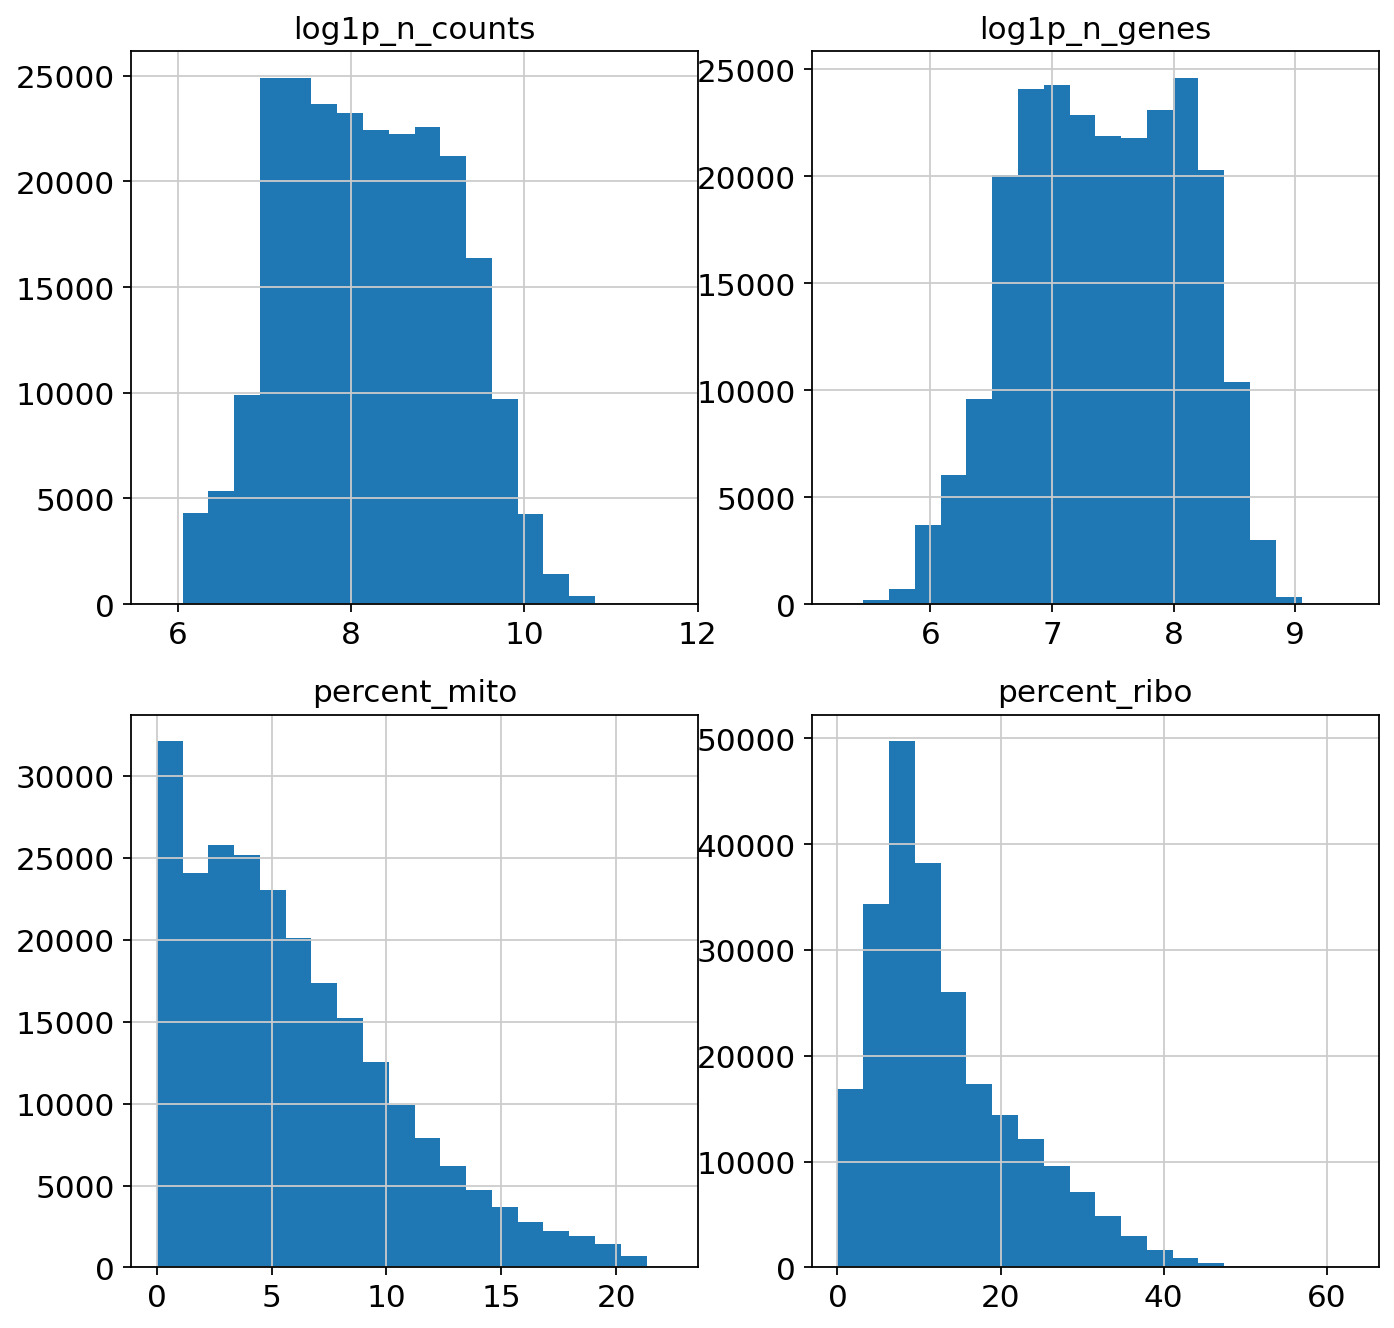

In [17]:
qc_obs = ["log1p_n_counts", "log1p_n_genes", "percent_mito", "percent_ribo"]
nrows_i=2; ncols_i=2; i = 0
fig, axs = plt.subplots(nrows=nrows_i, ncols=ncols_i)
for j in range(nrows_i):
    for k in range(ncols_i):
        if (len(qc_obs)-1) >= i:
            axs[j, k].hist(adata_obs[qc_obs[i]], bins=20)
            axs[j, k].set_title(qc_obs[i]); i+=1

### Remove doublets [if the info present] <a class="anchor" id="bullet5"></a>

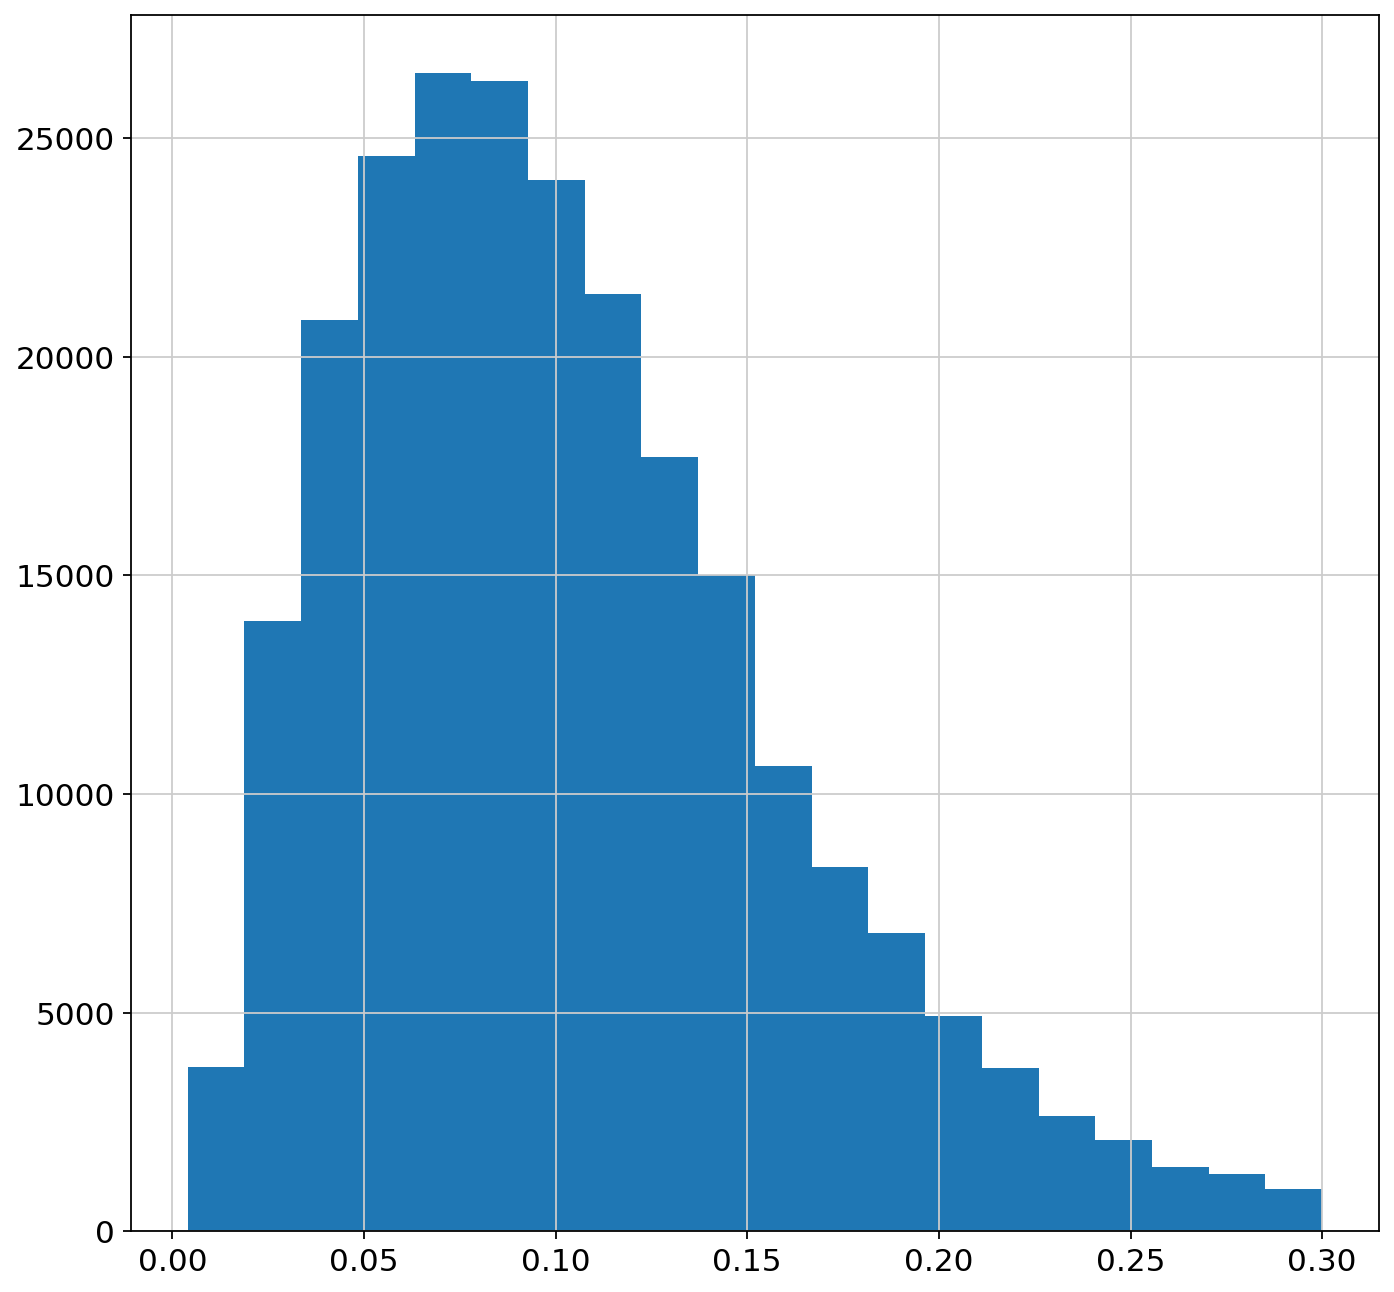

In [18]:
plt.hist(adata_obs['scrublet_score'], bins=20);

### Make object lightweight <a class="anchor" id="bullet6"></a>

Remove uns, varm, obsm, layers, and reduce obs columns if duplicated stuff or unlabelled clustering outputs exist.

In [19]:
del adata.uns
del adata.obsm
del adata.varm
del adata.obsp
adata

AnnData object with n_obs × n_vars = 236977 × 33582
    obs: 'institute', 'study_PI', 'sample_ID', 'subject_ID', 'subject_ID_published', 'subject_developmental_state', 'age_years', 'sex', 'ethnicity_1', 'smoking_status', 'smoking_history', 'bmi', 'disease_lung_known', 'disease_condition', 'subject_type', 'sample_type', 'anatomical_region_level1', 'protocol_tissue_dissociation', 'biological_unit', 'library_platform', 'strand_sequence', 'cell_enrichment', 'library_construction_batch', 'reference_genome', 'reads_processing', 'sample_collection_year', 'sample_status', 'sample_cultured', 'cell_number_loaded', 'cell_viability_percentage', 'study', 'dataset', 'sample', 'original_celltype_ann', 'ethnicity_free_text', 'disease_status'
    var: 'gene_ids', 'mito', 'ribo', 'sarscov2'

### Check if you need to split them into datasets <a class="anchor" id="bullet7"></a>

If different protocols were used, e.g., 10x versions, or if there were single-nuclei data or cryopreserved samples.

In this case there's one single donor with a different 10x version but we'll leave the dataset only divided by institute.

In [20]:
pd.crosstab(adata.obs.library_platform, adata.obs.dataset)

dataset,MeyerNikolic_unpubl_UCL,Meyer_Nikolic_unpubl_NW
library_platform,,
10x_5'_v1,74508,11672
10x_5'_v1.1,150161,0
10x_5'_v2,636,0


In [21]:
pd.crosstab(adata.obs.disease_status, adata_obs.dataset)

dataset,ucl,nw
disease_status,,
COVID+,92449,11672
Healthy,124189,0
Post-COVID,8667,0


In [22]:
pd.crosstab(adata.obs.library_platform, adata_obs.Group)

Group,Adult,Ped
library_platform,,
10x_5'_v1,11672,74508
10x_5'_v1.1,58198,91963
10x_5'_v2,0,636


In [23]:
pd.crosstab(adata.obs.disease_status, adata_obs.Group)

Group,Adult,Ped
disease_status,,
COVID+,49185,54936
Healthy,15611,108578
Post-COVID,5074,3593


In [24]:
pd.crosstab(adata.obs.disease_status, adata.obs.disease_condition)

disease_condition,Bronchial Asthma,Bronchiectasis,COPD,Healthy
disease_status,,,,
COVID+,1618,5848,5718,90937
Healthy,4555,0,0,119634
Post-COVID,3240,0,0,5427


We're taking only healthy subjects.

In [25]:
adata_healthy = adata[adata.obs.disease_status.isin(["Healthy"]),:].copy()

In [26]:
pd.crosstab(adata_healthy.obs.library_platform, adata_obs.loc[adata_healthy.obs.index,"Group"])

Group,Adult,Ped
library_platform,,
10x_5'_v1,0,74508
10x_5'_v1.1,15611,34070


In [27]:
pd.crosstab(adata_healthy.obs.library_platform, adata_obs.loc[adata_healthy.obs.index,"COVID_status"])

COVID_status,Healthy
library_platform,
10x_5'_v1,74508
10x_5'_v1.1,49681


#### Write down everything you did in the "preprocessing" column <a class="anchor" id="bullet8"></a>
Sheet: [Dataset overview](https://docs.google.com/spreadsheets/d/1V_dAIApfDG9Q1lsJGRePzDIosjn--ei-r7PKi9WWBsw/edit#gid=0&range=Q1).

### Subset to HVGs <a class="anchor" id="bullet8"></a>

Pad with 0s if needed.

* Genes: query_datasets/genes_for_mapping.csv
* Function: scripts/preprocessing.py

In [28]:
genes_set = pd.read_csv(genes_set_inp)
genes_set

,Unnamed: 0,gene_symbols
0,ENSG00000000938,FGR
1,ENSG00000000971,CFH
2,ENSG00000002587,HS3ST1
3,ENSG00000002933,TMEM176A
4,ENSG00000003436,TFPI
...,...,...
1995,ENSG00000280721,AC133644.2
1996,ENSG00000281103,TRG-AS1
1997,ENSG00000282122,CH17-262H11.1
1998,ENSG00000282988,RP1-34B20.21


In [29]:
adata_sub = pp.subset_and_pad_adata(genes_set, adata_healthy)

not all genes were recovered, filling in 0 counts for 92 missing genes...


In [30]:
adata_sub.var

,gene_ids,mito,ribo,sarscov2,gene_symbols,ensembl
FGR,ENSG00000000938,False,False,False,NaN,ENSG00000000938
CFH,ENSG00000000971,False,False,False,NaN,ENSG00000000971
HS3ST1,ENSG00000002587,False,False,False,NaN,ENSG00000002587
TMEM176A,ENSG00000002933,False,False,False,NaN,ENSG00000002933
TFPI,ENSG00000003436,False,False,False,NaN,ENSG00000003436
...,...,...,...,...,...,...
C10orf10,NaN,NaN,NaN,NaN,C10orf10,ENSG00000165507
FAM46C,NaN,NaN,NaN,NaN,FAM46C,ENSG00000183508
RP11-596C23.2,NaN,NaN,NaN,NaN,RP11-596C23.2,ENSG00000278002
RP11-51J9.5,NaN,NaN,NaN,NaN,RP11-51J9.5,ENSG00000271869


In [31]:
vars_keep = ["gene_ids", "gene_symbols", "ensembl"]
for i in list(set(adata_sub.var.columns) - set(vars_keep)):
    del adata_sub.var[i]

In [32]:
adata_sub

AnnData object with n_obs × n_vars = 124189 × 2000
    obs: 'institute', 'study_PI', 'sample_ID', 'subject_ID', 'subject_ID_published', 'subject_developmental_state', 'age_years', 'sex', 'ethnicity_1', 'smoking_status', 'smoking_history', 'bmi', 'disease_lung_known', 'disease_condition', 'subject_type', 'sample_type', 'anatomical_region_level1', 'protocol_tissue_dissociation', 'biological_unit', 'library_platform', 'strand_sequence', 'cell_enrichment', 'library_construction_batch', 'reference_genome', 'reads_processing', 'sample_collection_year', 'sample_status', 'sample_cultured', 'cell_number_loaded', 'cell_viability_percentage', 'study', 'dataset', 'sample', 'original_celltype_ann', 'ethnicity_free_text', 'disease_status'
    var: 'gene_ids', 'gene_symbols', 'ensembl'

### Store the data <a class="anchor" id="bullet10"></a>

Path: /storage/groups/ml01/workspace/hlca_lisa.sikkema_malte.luecken/query_datasets/ready
* full/ all genes
* subsetted/ 2000 genes

In [33]:
adata.write(adata_dir_out+'/full/meyer_nikolic_unpubl.h5ad')
adata_sub.write(adata_dir_out+'/subsetted/meyer_nikolic_unpubl.h5ad')

... storing 'institute' as categorical
... storing 'study_PI' as categorical
... storing 'sample_ID' as categorical
... storing 'subject_ID' as categorical
... storing 'subject_ID_published' as categorical
... storing 'subject_developmental_state' as categorical
... storing 'sex' as categorical
... storing 'ethnicity_1' as categorical
... storing 'smoking_status' as categorical
... storing 'disease_lung_known' as categorical
... storing 'disease_condition' as categorical
... storing 'subject_type' as categorical
... storing 'sample_type' as categorical
... storing 'anatomical_region_level1' as categorical
... storing 'protocol_tissue_dissociation' as categorical
... storing 'biological_unit' as categorical
... storing 'library_platform' as categorical
... storing 'strand_sequence' as categorical
... storing 'cell_enrichment' as categorical
... storing 'library_construction_batch' as categorical
... storing 'reference_genome' as categorical
... storing 'reads_processing' as categorical


#### Update the stats for your dataset <a class="anchor" id="bullet11"></a>
Sheet: [Dataset overview](https://docs.google.com/spreadsheets/d/1V_dAIApfDG9Q1lsJGRePzDIosjn--ei-r7PKi9WWBsw/edit#gid=0)